<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/shifted_julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [2]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-bzbe8xah
  Stored in directory: /tmp/pip-ephem-wheel-cache-ga30j1gx/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [4]:
%%cu
#include <iostream>
int main() {
    std::cout << "Hello world!";
    return 0;
}

'Hello world!'

In [11]:
%%cu
#include<stdio.h>
#include<stdlib.h>
#include<iostream>

#define DIM 1000

struct cuComplex { 
  float r; 
  float i;
  __device__ cuComplex( float a, float b ) : r(a), i(b) {} 
  __device__ float magnitude2( void ) {
    return r * r + i * i;
  }
  __device__ cuComplex operator*(const cuComplex& a) {
    return cuComplex(r*a.r - i*a.i, i*a.r + r*a.i);
  }
  __device__ cuComplex operator+(const cuComplex& a) {
    return cuComplex(r+a.r, i+a.i);
  }
};

__device__ int julia( int x, int y ) {
  const float scale = 1.5;
  float jx = scale * (float)(DIM/2 - x)/(DIM/2);
  float jy = scale * (float)(DIM/2 - y)/(DIM/2);
  cuComplex c(-0.8, 0.156);
  cuComplex a(jx, jy);
  int i = 0;
  for (i=0; i<200; i++) {
    a = a * a + c;
    if (a.magnitude2() > 1000)
      return 0;
  }
  return 1;
}

__global__ void kernel( int *ptr ) {

  // map from threadIdx/BlockIdx to pixel position 
  int x = blockIdx.x;
  int y = blockIdx.y;
  int offset = x + y * gridDim.x;
  
  // now calculate the value at that position
  int juliaValue = julia( x, y ); 
  ptr[offset] = juliaValue;
    
}

int main( void ) {

  int bitmap[DIM*DIM];
    
  int *dev_bitmap;
  cudaMalloc( (void**)&dev_bitmap, DIM*DIM*sizeof(int) );
  dim3    grid(DIM,DIM);
  kernel<<<grid,1>>>( dev_bitmap );
  cudaMemcpy( bitmap, dev_bitmap, DIM*DIM*sizeof(int), cudaMemcpyDeviceToHost );
  cudaFree( dev_bitmap );
    
  for (int i=0; i<DIM*DIM; i++) printf("%d ", bitmap[i]);
  
    
  FILE *myfile;
  myfile=fopen("/tmp/test.bin","wb");
  if (!myfile) {
	  printf("Unable to open file!");
	  return 1;
	}
  fwrite(bitmap, sizeof(int), DIM*DIM, myfile);
  fclose(myfile);
    
  std::cout << "Success!";
}

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

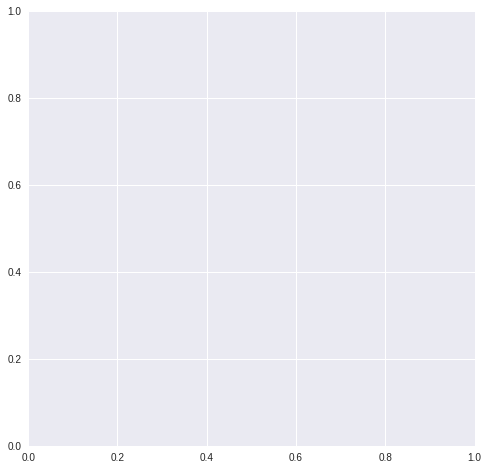

In [10]:
import matplotlib.pyplot as plt
import numpy as np

bitmap = np.fromfile('/tmp/test.bin', dtype=np.int32)
bitmap

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.imshow(a.T, origin="lower")

In [0]:
!rm /tmp/test.bin

rm: cannot remove '/tmp/test.bin': No such file or directory
